In [189]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(42)

## Various sine function

In [190]:
# Time Domain Function
T = 2  # seconds
fs = 5000  # Hz
frequencies = [20,90]  # Hz
t = torch.arange(0, T, 1 / fs)
L = len(t)

#### sum of sines

In [191]:
sine_wave = torch.zeros_like(t)
for freq in frequencies:
    sine_wave += torch.sin(2 * np.pi * freq * t)

#### changing freq

In [192]:
transition_point = 3000  # Number of samples before frequency transition
changing_sine = torch.zeros_like(t)
changing_sine[:transition_point] = torch.sin(2 * torch.pi * frequencies[0] * t[:transition_point])
changing_sine[transition_point:] = torch.sin(2 * torch.pi * frequencies[-1] * t[transition_point:])

#### chirp

In [193]:
f0 = frequencies[0]  # starting frequency in Hz
fn = frequencies[-1]  # ending frequency in Hz
t = torch.linspace(0, T, int(T * fs), dtype=torch.float32)
omega = 2 * torch.pi * (f0 + (fn - f0) * t / T)
chirp = torch.sin(omega * t)

#### real force data

In [194]:
forces = torch.load('/home/hadar/Thesis/Results/22_11_2023/f19+f23_list_clean.pt')

In [195]:
random_force_index = random.randint(0, len(forces) - 1)
f_dataset = forces[random_force_index]
window_size = 480
window_start = random.randint(0, len(f_dataset) - window_size)
window_end = window_start + window_size
window = f_dataset[window_start:window_end, :]

f1, f2, f3, f4 = window[:, 0], window[:, 1], window[:, 2], window[:, 3]
print('dataset index:', random_force_index, f'(out of {len(forces) - 1})')
print(f'window index: [{window_start}, {window_start + 1},...,{window_end}] (size {window_size})',
      f'within the dataset with indices [0,1,...,{len(f_dataset) - 1}] (size {len(f_dataset)})')


dataset index: 70 (out of 152)
window index: [1634, 1635,...,2114] (size 480) within the dataset with indices [0,1,...,3733] (size 3734)


In [196]:
class Dataset:
    def __init__(self, data, name, fs):
        self.name = name
        self.data = data
        self.fft = None
        self.fftfreq = None
        self.stft = None
        self.fs = fs

    def __str__(self):
        if self.name == 'sine':
            return r'$f(t)=$' + '+'.join([rf'$sin(2\pi\cdot{f}t)$' for f in frequencies])
        else:
            return self.name

    def calc_fft(self, apply_abs=True, trim_negative=True, shapes=True):
        fft = torch.fft.fft(self.data)
        freqs = torch.fft.fftfreq(len(self.data), 1 / self.fs)
        if trim_negative:
            freqs_mask = freqs >= 0
            freqs = freqs[freqs_mask]
            fft = fft[freqs_mask]
        if apply_abs:
            fft = torch.abs(fft)
        self.fft = fft
        self.fftfreq = freqs
        if shapes:
            print(fft.shape)

    def calc_stft(self, n_fft=200, hop_length=None, win_length=None, pad_mode='reflect', apply_abs=True, shapes=True):
        if win_length is None:
            win_length = n_fft
        if hop_length is None:
            hop_length = n_fft // 4
        stft = torch.stft(
            input=self.data,
            n_fft=n_fft,
            hop_length=hop_length,  #default n_fft/4
            win_length=win_length,  #default n_fft
            window=torch.hann_window(win_length),  # hann is a cosine window with ends that touch zero
            center=False, 
            pad_mode=pad_mode,
            normalized=False,  # not normalized
            onesided=True,  # only return the positive frequencies
            return_complex=True  # return complex numbers
        )
        if apply_abs:
            stft = torch.abs(stft)
        self.stft = stft
        if shapes:
            print("Spectrogram shape is (B?, N, T, C?), where:")
            print(f' - B --> None')
            print(f' - N --> (n_fft//2)+1=({n_fft}//2)+1={(n_fft // 2) + 1}')
            print(f" - T --> 1+(L-n_fft)//hop_length=1+({len(self.data)}-{n_fft})//{hop_length}={1 + (len(self.data)-n_fft)// hop_length}")
            print(f" - C --> None")
            print(f'STFT shape: {stft.shape}')



In [197]:
dataset = Dataset(f3, 'f3',fs=fs)
dataset.calc_fft()
n_fft=int(0.5 * len(dataset.data))
hop_length=1
dataset.calc_stft(n_fft=n_fft,hop_length=hop_length)

torch.Size([240])
Spectrogram shape is (B?, N, T, C?), where:
 - B --> None
 - N --> (n_fft//2)+1=(240//2)+1=121
 - T --> 1+(L-n_fft)//hop_length=1+(480-240)//1=241
 - C --> None
STFT shape: torch.Size([121, 241])


In [198]:
k = 2
sorted_fft = torch.sort(dataset.fft,descending=True)
top_k_freqs = dataset.fftfreq[sorted_fft.indices[:k]]

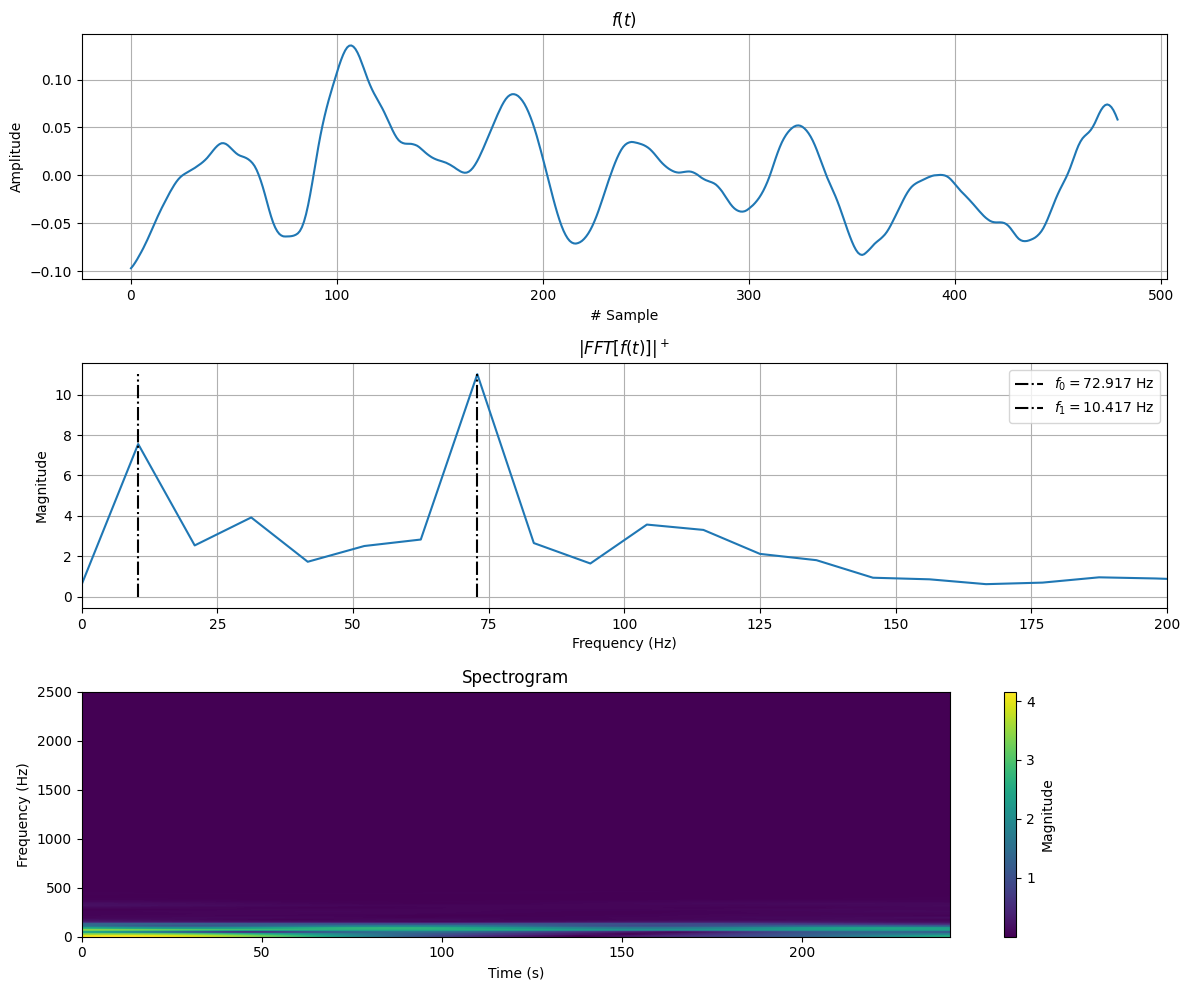

In [201]:
plt.figure(figsize=(12, 10))

# Subplot 1: Input signal
plt.subplot(3, 1, 1)
plt.plot(dataset.data)
plt.title(r'$f(t)$'), plt.xlabel('# Sample'), plt.ylabel('Amplitude'), plt.grid()

# Subplot 2: FFT
plt.subplot(3, 1, 2)
plt.plot(dataset.fftfreq, dataset.fft)
plt.title(r'$|FFT[f(t)]|^+$'), plt.xlabel('Frequency (Hz)'), plt.ylabel('Magnitude'), plt.grid()
for i, f in enumerate(top_k_freqs):
    plt.vlines(x=f, ymin=0, ymax=max(dataset.fft), color='black', linestyle='-.',
               label=rf'$f_{i}={f:.3f}$ Hz')
plt.xlim(0, 200)
plt.legend()

# Subplot 3: Spectrogram
plt.subplot(3, 1, 3)
stft_np = dataset.stft.numpy()
plt.imshow(stft_np, aspect='auto', cmap='viridis', origin='lower', extent=[0, stft_np.shape[1], 0, fs/2])
plt.colorbar(label='Magnitude')
plt.title('Spectrogram'), plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
# plt.ylim(0, max(top_k_freqs) + 10)
plt.tight_layout()
plt.show()



In [200]:
stft_np.shape

(121, 241)